In [1]:
import pandas as pd
import numpy as np

import re
import string
# BERT-Embeddings
from keybert import KeyBERT
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
#import altair as alt
#alt.renderers.enable('mimetype')
from sklearn.metrics.pairwise import cosine_similarity

/home/haochenyang/personal/miniconda3/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-06 15:09:24.806145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 15:09:25.469691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preprocessing Data

# 2. Word2Vec

In [2]:
book_data2 = pd.read_csv('preprocess_book.csv')[:5000]
book_data2.head()

,Unnamed: 0,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber,keywords,features
0,0,1100003,the prince,niccolò_machiavelli,1998,university_of_chicago_press,the most famous book on politics ever written ...,3.82,151,machiavellis machiavelli prince tyranny biblio...,niccolò_machiavelli university_of_chicago_press
1,1,1100004,"sermons from duke chapel: voices from ""a great...",william_h._willimon,2005,duke_university_press_books,many of america’s greatest protestant preacher...,4.29,384,sermons sermon preacher pulpit preachers,william_h._willimon duke_university_press_books
2,3,1100009,the idea of a university,john_henry_newman,1996,yale_university_press,since its publication almost 150 years ago the...,4.12,400,scholars universities university academic newman,john_henry_newman yale_university_press
3,4,1100010,caring and curing: health and medicine in the ...,ronald_l._numbers,1997,johns_hopkins_university_press,most religious traditions have a rich if large...,3.00,622,judeochristian medicine religious religion med...,ronald_l._numbers johns_hopkins_university_press
4,6,1100013,the alamo remembered: tejano accounts and pers...,timothy_matovina,1995,university_of_texas_press,as mexican soldiers fought the mostly angloame...,3.77,146,alamo tejanos 1836 tejano antonians,timothy_matovina university_of_texas_press


In [3]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

In [4]:
corpus = book_data2['Description'].to_list()
corpus2 = []
for doc in corpus:
    if type(doc) == str:
        # print(doc)
        corpus2.append(doc.split(' '))
    else:
        print(doc)
    
# corpus = [doc for doc in corpus if len(doc) > 1]
# corpus

nan
nan


In [ ]:
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
import numpy as np

pretrained_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
# Convert corpus2 to list of lists of words
# sentences = [simple_preprocess(text) for text in corpus2 if isinstance(text, str)]

# Initialize model with pretrained vectors
model = Word2Vec(vector_size=300, min_count=1)
model.build_vocab(corpus2)
model.wv.vectors_lockf = np.ones(len(model.wv))
model.wv.vectors = pretrained_model.vectors

# Fine-tune on corpus2
model.train(corpus2, total_examples=len(corpus2), epochs=5)

# Use the fine-tuned vectors
pretrained_model = model.wvmodel = pretrained_model
model = pretrained_model

def description_to_embedding(description):
    if description is np.nan:
        return np.zeros(model.vector_size) 
    words = simple_preprocess(description)
    word_vectors = [model[word] for word in words if word in model]
    
    if not word_vectors:  
        return np.zeros(model.vector_size)  
    

    embedding = np.mean(word_vectors, axis=0)
    return embedding

book_data2['Description_Embedding'] = book_data2['Description'].apply(description_to_embedding)

print(book_data2[['Description', 'Description_Embedding']])

                                            Description  \
0     the most famous book on politics ever written ...   
1     many of america’s greatest protestant preacher...   
2     since its publication almost 150 years ago the...   
3     most religious traditions have a rich if large...   
4     as mexican soldiers fought the mostly angloame...   
...                                                 ...   
4995  this book argues that congresss process for ma...   
4996  a raft of recent political scandals in austral...   
4997  this book addresses key topics essential to pa...   
4998  it was a day when max didnt feel like talking ...   
4999  many graphic novels have attempted to ground i...   

                                  Description_Embedding  
0     [0.1820117, 0.12425397, 0.26619583, 0.32213676...  
1     [0.22629857, 0.13039362, 0.34770572, 0.4063314...  
2     [0.20906141, 0.09674776, 0.41418988, 0.4800971...  
3     [0.14186226, 0.13609432, 0.28245375, 0.386673,...  
4

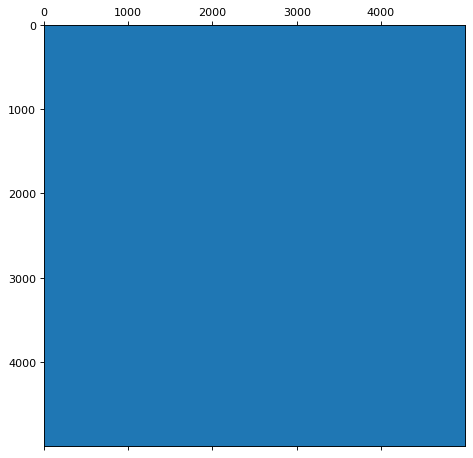

In [7]:
book_tfidf_w2v_matrix = np.array(book_data2['Description_Embedding'].tolist())
book_cosine_sim_w2v = cosine_similarity(book_tfidf_w2v_matrix, book_tfidf_w2v_matrix)
book_cosine_sim_w2v
# Vidualize similarity between books
plt.figure(figsize=(6, 6), dpi=80)
plt.spy(book_cosine_sim_w2v, precision = 0.1, markersize = 0.01)
plt.tight_layout()
plt.show()

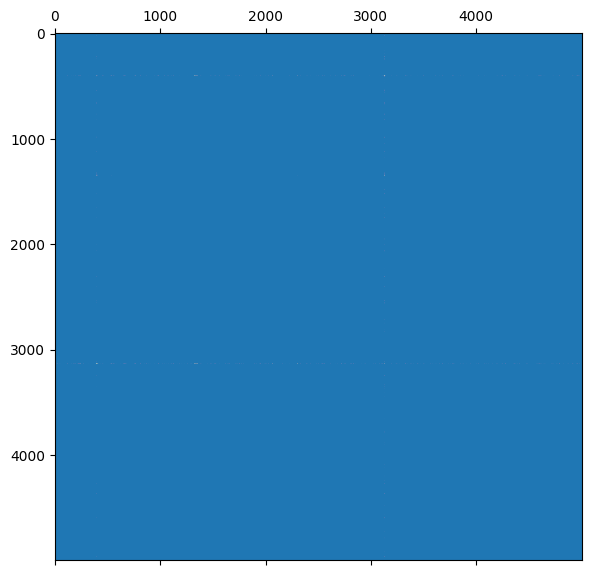

In [9]:
# Vidualize similarity between books
plt.figure(figsize=(6, 6), dpi=100)
plt.spy(book_cosine_sim_w2v, precision = 0.9, markersize = 0.005)
plt.tight_layout()
plt.show()

In [10]:
np.save('book_cosine_sim_w2v.npy', book_cosine_sim_w2v)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
def plot_graph(book_cosine_sim, thresh=0.5):
    threshold = thresh  
    sparse_sim = (book_cosine_sim > threshold).astype(int)

    G = nx.Graph()

    G.add_nodes_from(range(len(book_cosine_sim)))

    for i in range(len(book_cosine_sim)):
        for j in range(i + 1, len(book_cosine_sim)):
            if sparse_sim[i, j] == 1:
                G.add_edge(i, j, weight=book_cosine_sim[i, j])


    min_degree = 3 
    G = G.subgraph([node for node, degree in G.degree() if degree >= min_degree])

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  

    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.8)

    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v) for u, v, d in edges],
        width=[d['weight'] * 2 for u, v, d in edges],  
        alpha=0.5, edge_color='gray'
    )

    plt.title("Sparse Book Similarity Network (Higher Threshold) By Word2Vec", fontsize=16)
    plt.axis('off')
    plt.show()


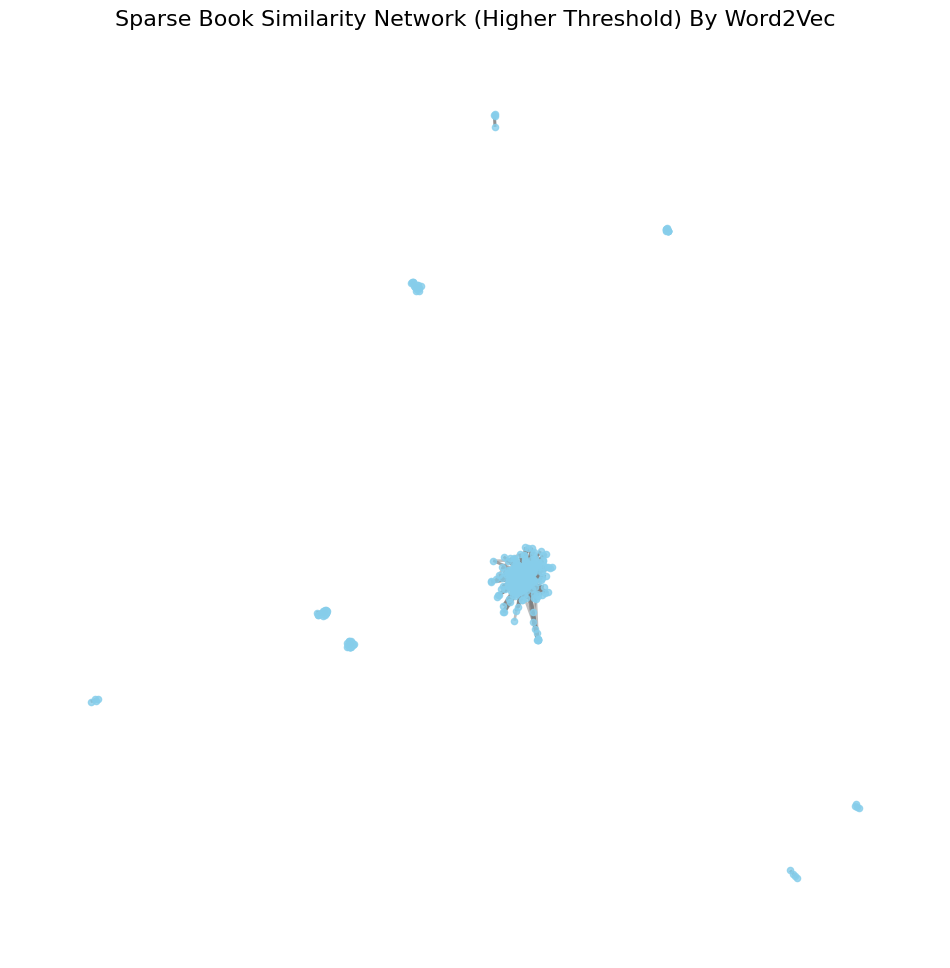

In [12]:
plot_graph(book_cosine_sim_w2v, thresh = 0.94)